# Analyze Large Datasets with Sampling Using Pandas

The data for this notebook comes from Amex's Kaggle Competition https://www.kaggle.com/competitions/amex-default-prediction .

The training dataset is just over 16GBs big. It's over 5.5M rows with 190 columns. I do not include the data with this notebook. To download the dataset, please go to the competition link.

The idea behind this notebook is to show that using a fraction of the data (in this case 10%, possibly less could be used) suffices in being able to understand the 5.5M+ rows of data and that 1 doesn't have to go beyond Pandas to accomplish this task.

To show that a fraction of the data is representative of the greater dataset, we look at the distribution of the sample. You'll realize that the distibution at 10% is essentially identical to that of 100%.

Note: the following columns, because they're either ID columns, date columns or categorical columns, are not accounted for during this exercise. Because of that reason do NOT try to look at the distribution of the following columns, it WILL break the code:
+ ID
+ S_2
+ B_30
+ B_38
+ D_114
+ D_116
+ D_117
+ D_120
+ D_126
+ D_63
+ D_64
+ D_66
+ D_68

The following practices are used in this notebook to iterate through the data and choose a random sample:
+ Pandas chunksize is used to iterate through the dataset.
+ The function to iterate only allows 1 column at a time.
+ The smallest possible float size is used when importing the data (mainly float16).
+ The values of the floats are rounded to 4 decimal places, which ensures that there aren't more than 10k possible distinct values to hold

Lastly, BEFORE going over the code, it's important to realize that this is NOT production code. It is NOT tested and it WILL break if provided the wrong values. The code in this notebook is for demonstration purposes ONLY.

## The Code

For the purposes of this demonstration I had to create a custom histogram plot for the larger dataset (I still use matplotlib's histogram for the sample dataset). The histogram_from_freq function is a function that creates a histogram plot from a Pandas value_counts object. The bins parameter specifies the number of bins in the histogram, and the width parameter specifies the width of the bars in the plot.

The get_bins function returns an array of bin intervals using NumPy's linspace. The histogram_from_freq function iterates over these intervals and uses them to calculate the frequencies for each bin. It then plots the histogram using Matplotlib's bar and returns the frequencies and the bin intervals.

Note: Because I made my own historgram function, you'll see that I change the width parameter below to make sure that bar widths are the same as those of Matplotlib's.

The get_full_and_sample_col_distributions function reads in a csv file in chunks and assigns the smallest float size. For each chunk, it samples a portion of the data specified by the frac parameter (10% for the distributions shown below), and concatenates it to the greater random_sample dataframe. It also calculates the rounded off value counts (rounded to 4 decimal places) for each chunk and concatenates it to the greater full_data dataframe. The function returns the full_data and random_sample Pandas series.

The plot_full_and_sample_distributions function plots histograms for both the random sample and full dataset. It also returns the result of the histogram calculations for both the random sample and full dataset.

Note: At some points, I use full_data[full_data>1] when calling plot_full_and_sample_distributions. It's to remove any 1 off values from the full dataset that zoom out the distribution.

In [ ]:
!pip install -q numpy==1.20.3
!pip install -q pandas==1.5.0
!pip install -q matplotlib==3.4.3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_bins(value_counts, bins):
    offset = 1e-6
    start = value_counts.index.min()-offset
    stop = value_counts.index.max()+offset
    return np.linspace(start=start, stop=stop, num=bins+1)

def histogram_from_freq(value_counts, bins=50, width=0.03):
    freq = []
    bin_intervals = get_bins(value_counts, bins=bins)
    for interval in zip(bin_intervals[:-1], bin_intervals[1:]):
        greater_equal_than_min = (value_counts.index >= min(interval))
        less_than_max = (value_counts.index < max(interval))
        freq.append(value_counts[greater_equal_than_min & less_than_max].sum())
    
    freq = np.array(freq)
    plt.bar(bin_intervals[1:], freq, width=width)
    return freq, bin_intervals

In [ ]:
def get_float_size(col):
    float_32 = ['D_43', 'B_5', 'B_6', 'D_50', 'R_3', 'B_10', 'S_5', 'B_12', 'B_13', 'R_5', 'B_14', 'D_61', 'B_15', 'D_65', 'S_12', 'R_6', 'B_21', 'D_69', 'D_71', 
                'B_24', 'R_7', 'B_26', 'R_8', 'S_16', 'R_10', 'D_81', 'B_28', 'R_14', 'D_84', 'R_16', 'R_20', 'S_22', 'S_23', 'S_24', 'S_26', 'D_106', 'B_40', 'B_41']
    float_64 = ['D_41', 'D_46', 'D_49', 'B_9', 'D_56', 'D_62', 'D_76', 'D_77', 'D_78', 'D_83', 'B_29', 'D_125', 'B_42']
    
    if(col in float_64):
        return np.float64
    elif(col in float_32):
        return np.float32
    else:
        return np.float16
    
def get_full_and_sample_col_distributions(file_path, col, chunksize=500000, frac=0.1, decimals=4, random_state=np.random.RandomState(123)):
    full_data = pd.DataFrame()
    random_sample = pd.DataFrame()
    float_size = get_float_size(col)

    data = pd.read_csv(file_path, usecols=[col], dtype={col: float_size}, chunksize=chunksize)
    for chunk in data:
        random_sample_from_chunk = chunk.sample(frac=frac, random_state=random_state)
        rounded_off_value_counts = chunk[col].round(decimals=decimals).value_counts()
        random_sample = pd.concat([random_sample, random_sample_from_chunk])
        full_data = pd.concat([full_data, rounded_off_value_counts]).groupby(level=0).sum()

    return full_data.squeeze(), random_sample.squeeze()

def plot_full_and_sample_distributions(random_sample, full_dataset, frac, bins=50, width=0.03):
    plt.subplot(1, 2, 1)
    result_from_sample = plt.hist(random_sample, bins=bins)
    plt.title('Sample of {0}%'.format(frac*100))
    
    plt.subplot(1, 2, 2)
    result_from_full = histogram_from_freq(full_dataset, bins=bins, width=width)
    plt.title('All Data')
    
    plt.tight_layout()
    plt.show()
    return result_from_sample, result_from_full

In [ ]:
file_path = r'train_data.csv'
frac = 0.1

In [ ]:
full_data, random_sample = get_full_and_sample_col_distributions(file_path=file_path, col='B_7', frac=frac)

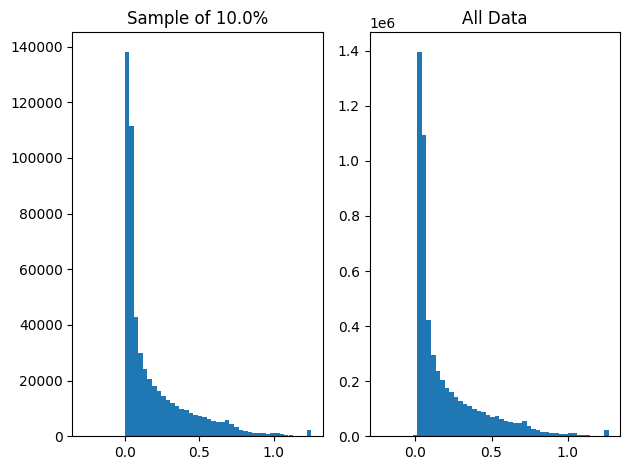

((array([2.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
         4.00000e+00, 7.00000e+00, 1.80000e+01, 2.65000e+02, 1.38210e+05,
         1.11414e+05, 4.26860e+04, 2.98050e+04, 2.40730e+04, 2.06030e+04,
         1.81050e+04, 1.62690e+04, 1.43540e+04, 1.30390e+04, 1.19100e+04,
         1.09390e+04, 9.86800e+03, 9.46500e+03, 8.36500e+03, 7.62300e+03,
         7.20800e+03, 7.07700e+03, 6.05400e+03, 5.55800e+03, 5.08800e+03,
         5.05800e+03, 5.69500e+03, 4.44000e+03, 3.17600e+03, 2.40600e+03,
         1.85000e+03, 1.59700e+03, 1.33000e+03, 1.14000e+03, 1.04300e+03,
         9.83000e+02, 1.03700e+03, 1.14900e+03, 7.10000e+02, 4.10000e+02,
         3.19000e+02, 2.69000e+02, 2.07000e+02, 2.13000e+02, 2.10200e+03]),
  array([-0.2778  , -0.2472  , -0.2166  , -0.186   , -0.1554  , -0.12476 ,
         -0.0941  , -0.06354 , -0.0329  , -0.002295,  0.02832 ,  0.05893 ,
          0.08954 ,  0.1202  ,  0.1508  ,  0.1814  ,  0.212   ,  0.2427  ,
          0.2732  ,  0.304   ,  0

In [ ]:
plot_full_and_sample_distributions(random_sample, full_data[full_data>1], frac=frac, width=0.03)

In [ ]:
full_data, random_sample = get_full_and_sample_col_distributions(file_path=file_path, col='P_2', frac=frac)

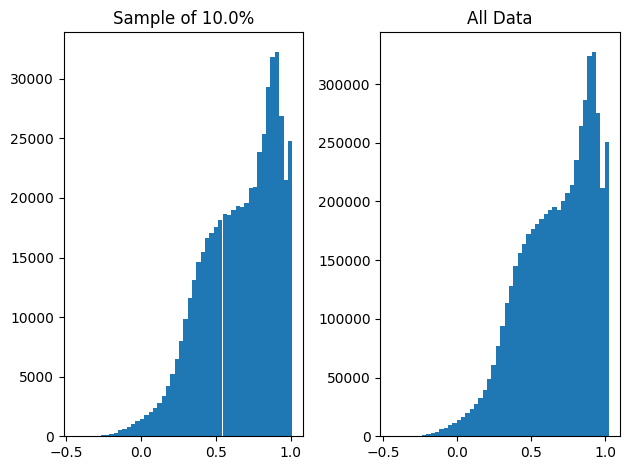

((array([1.0000e+00, 1.0000e+00, 0.0000e+00, 7.0000e+00, 2.0000e+01,
         3.4000e+01, 8.0000e+01, 1.2100e+02, 2.1400e+02, 3.1000e+02,
         4.8600e+02, 5.9900e+02, 7.7200e+02, 1.0030e+03, 1.2480e+03,
         1.4830e+03, 1.7530e+03, 2.0380e+03, 2.3400e+03, 2.8300e+03,
         3.4070e+03, 4.2340e+03, 5.2680e+03, 6.4820e+03, 8.0090e+03,
         9.8260e+03, 1.1607e+04, 1.3112e+04, 1.4597e+04, 1.5476e+04,
         1.6625e+04, 1.7089e+04, 1.7526e+04, 1.8146e+04, 1.8687e+04,
         1.8571e+04, 1.8978e+04, 1.9332e+04, 1.9211e+04, 1.9617e+04,
         2.0813e+04, 2.0893e+04, 2.3895e+04, 2.5346e+04, 2.9336e+04,
         3.1853e+04, 3.2284e+04, 2.6882e+04, 2.1509e+04, 2.4743e+04]),
  array([-0.4426 , -0.4136 , -0.3845 , -0.3555 , -0.3264 , -0.2974 ,
         -0.2683 , -0.2393 , -0.2102 , -0.1812 , -0.1521 , -0.1231 ,
         -0.09406, -0.065  , -0.03595, -0.00691,  0.02214,  0.05118,
          0.08026,  0.10925,  0.1383 ,  0.1674 ,  0.1964 ,  0.2255 ,
          0.2546 ,  0.2837 ,  0.

In [ ]:
plot_full_and_sample_distributions(random_sample, full_data, frac=frac, width=0.03)

In [ ]:
full_data, random_sample = get_full_and_sample_col_distributions(file_path=file_path, col='R_16', frac=frac)

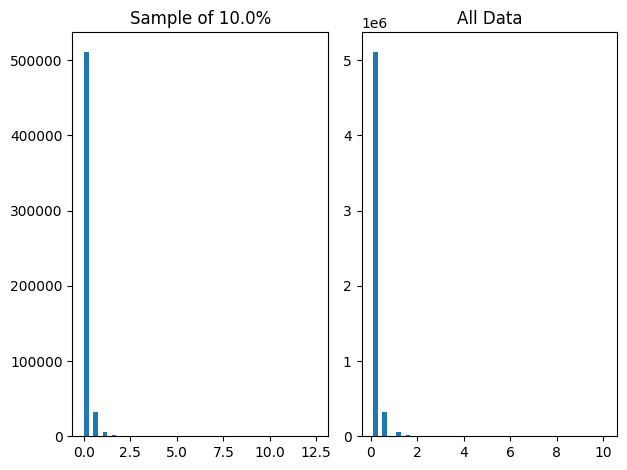

((array([5.11462e+05, 3.79000e+02, 3.18260e+04, 1.34000e+02, 5.76300e+03,
         5.30000e+01, 1.82300e+03, 3.80000e+01, 6.99000e+02, 1.70000e+01,
         4.16000e+02, 1.50000e+01, 1.91000e+02, 1.10000e+01, 9.80000e+01,
         1.00000e+01, 6.80000e+01, 2.00000e+00, 3.10000e+01, 2.00000e+00,
         2.10000e+01, 2.00000e+00, 2.80000e+01, 3.00000e+00, 1.40000e+01,
         2.00000e+00, 6.00000e+00, 0.00000e+00, 5.00000e+00, 2.00000e+00,
         6.00000e+00, 2.00000e+00, 4.00000e+00, 1.00000e+00, 3.00000e+00,
         0.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
         2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
  array([1.4509617e-08, 2.5005543e-01, 5.0011086e-01, 7.5016630e-01,
         1.0002217e+00, 1.2502772e+00, 1.5003326e+00, 1.7503880e+00,
         2.0004435e+00, 2.2504988e+00, 2.5005543e+00, 2.7506096e+00,
         3.0006652e+00, 3.2507205e+00, 3.5007761e+0

In [ ]:
plot_full_and_sample_distributions(random_sample, full_data[full_data>1], frac=frac, width=0.2)